In [1]:
import pandas as pd
import pybedtools
from glob import glob

In [2]:
peaks_dict = {}
bedtools_dict = {}
for f in glob('6.2_peaks_with_sequences/*cleaned.tsv'):
    print(f)
    
    peaks = pd.read_csv(f, sep='\t')
    peaks.columns =['label', 'sequence']
    
    peaks['symbol'] = [l.split('|')[1].split(':')[0] for l in peaks.label]
    peaks['enzyme'] = enzyme = f.split('FOX2-')[1].split('_cleaned')[0]
    peaks['chrom'] = [l.split(':')[0] for l in peaks.label]
    peaks['start'] = [l.split(':')[1].split('-')[0] for l in peaks.label]
    peaks['end'] = [l.split(':')[1].split('-')[1].split('(')[0] for l in peaks.label]
    peaks['strand'] = [l.split('(')[1].split(')')[0] for l in peaks.label]

    print('\t', len(peaks))
    peaks = peaks[['chrom', 'start', 'end', 'enzyme', 'symbol', 'strand', 'label', 'sequence']]
    peaks_dict[enzyme] = peaks
    
    bedtools_dict[enzyme] = pybedtools.BedTool.from_dataframe(peaks)

6.2_peaks_with_sequences/RBFOX2_ai_FOX2-8e_cleaned.tsv
	 7861
6.2_peaks_with_sequences/RBFOX2_ct_FOX2-APOBEC1_cleaned.tsv
	 1888
6.2_peaks_with_sequences/RBFOX2_both_FOX2-P0078_cleaned.tsv
	 3996
6.2_peaks_with_sequences/RBFOX2_ai_FOX2-MinA_cleaned.tsv
	 735


bedtools_dict# Merge all to get union

In [3]:
bedtools_dict

{'8e': <BedTool(/scratch/ekofman/31426606.tscc-mgr7.local/pybedtools.36h518ft.tmp)>,
 'APOBEC1': <BedTool(/scratch/ekofman/31426606.tscc-mgr7.local/pybedtools.gmgc2ys1.tmp)>,
 'P0078': <BedTool(/scratch/ekofman/31426606.tscc-mgr7.local/pybedtools.ff54dxz0.tmp)>,
 'MinA': <BedTool(/scratch/ekofman/31426606.tscc-mgr7.local/pybedtools.rqx_6_lv.tmp)>}

In [4]:
unioned = bedtools_dict.get('8e').cat(bedtools_dict.get("APOBEC1"), postmerge=False)\
.cat(bedtools_dict.get('P0078'), postmerge=False).cat(bedtools_dict.get('MinA'), postmerge=False)
len(unioned)

unioned = unioned.sort().merge(c=(4, 5, 6), o=('distinct', 'distinct', 'distinct'))
bedtools_dict['unioned'] = unioned

In [6]:
bedtools_dict.get('unioned').saveas('9.4_unioned_peaks/unioned_cleaned_peaks.bed')

<BedTool(9.4_unioned_peaks/unioned_cleaned_peaks.bed)>

# Load eCLIP

In [99]:
import pybedtools

def load_eclip(filepath, l2fc_threshold=2, l10p_threshold=3):
    print(filepath)
    eclip_df = pd.read_csv(filepath,
                               sep='\t'
                               )

    total_columns = len(eclip_df.columns)
    
    eclip_df.columns=['chrom', 'start', 'end', 'l2fc', 'l10p', 'strand'] + [i for i in range(total_columns - 6)]
    print('\tBefore filter:', len(eclip_df))

    if 'region' in eclip_df.columns:
        eclip_df = eclip_df[~eclip_df.region.isin([
            'distintron500', 'proxintron500', 'distnoncoding_intron500', 'proxnoncoding_intron500', 'intergenic'
        ])]
        
    eclip_df = eclip_df[(eclip_df.l2fc > l2fc_threshold) & (eclip_df.l10p > l10p_threshold)]
    
    eclip_df['chrom'] = [i.split('chr')[1] for i in eclip_df.chrom]
    print('\tAfter filter: ', len(eclip_df))
    eclip_bed = pybedtools.BedTool.from_dataframe(eclip_df)

    return eclip_bed


overall_path = '/projects/ps-yeolab3/ekofman/Hugo/Full_RBFOX2_and_SLBP/reference/hg38_eCLIPs'
rbfox2_native_path = '{}/RBFOX2_native_eclip.bed.annotated'.format(overall_path)
rbfox2_cterm_path = '{}/RBFOX2_CTerminus_1.bed.annotated'.format(overall_path)

eclips = {
    #'rbfox2_native': load_eclip(rbfox2_native_path),
    #'rbfox2_cterm_l2fc_1': load_eclip(rbfox2_cterm_path, l2fc_threshold=1),
    'rbfox2_cterm_l2fc_2': load_eclip(rbfox2_cterm_path, l2fc_threshold=2),
    #'rbfox2_cterm_l2fc_3': load_eclip(rbfox2_cterm_path, l2fc_threshold=3),
    'rbfox2_cterm_l2fc_4': load_eclip(rbfox2_cterm_path, l2fc_threshold=4),
    #'rbfox2_cterm_l2fc_5': load_eclip(rbfox2_cterm_path, l2fc_threshold=5),
    'rbfox2_cterm_l2fc_6': load_eclip(rbfox2_cterm_path, l2fc_threshold=6),
    #'rbfox2_cterm_l2fc_7': load_eclip(rbfox2_cterm_path, l2fc_threshold=7),
    'rbfox2_cterm_l2fc_8': load_eclip(rbfox2_cterm_path, l2fc_threshold=8),
    #'rbfox2_cterm_l2fc_9': load_eclip(rbfox2_cterm_path, l2fc_threshold=9),
    'rbfox2_cterm_l2fc_10': load_eclip(rbfox2_cterm_path, l2fc_threshold=10)
}

/projects/ps-yeolab3/ekofman/Hugo/Full_RBFOX2_and_SLBP/reference/hg38_eCLIPs/RBFOX2_CTerminus_1.bed.annotated
	Before filter: 263128
	After filter:  16870
/projects/ps-yeolab3/ekofman/Hugo/Full_RBFOX2_and_SLBP/reference/hg38_eCLIPs/RBFOX2_CTerminus_1.bed.annotated
	Before filter: 263128
	After filter:  12785
/projects/ps-yeolab3/ekofman/Hugo/Full_RBFOX2_and_SLBP/reference/hg38_eCLIPs/RBFOX2_CTerminus_1.bed.annotated
	Before filter: 263128
	After filter:  9864
/projects/ps-yeolab3/ekofman/Hugo/Full_RBFOX2_and_SLBP/reference/hg38_eCLIPs/RBFOX2_CTerminus_1.bed.annotated
	Before filter: 263128
	After filter:  7584
/projects/ps-yeolab3/ekofman/Hugo/Full_RBFOX2_and_SLBP/reference/hg38_eCLIPs/RBFOX2_CTerminus_1.bed.annotated
	Before filter: 263128
	After filter:  5670


In [109]:
def calculate_bed_intersection_fraction(stamp_bed, eclip_bed):
    intersection = stamp_bed.intersect(eclip_bed, s=True, u=True)
    fraction_overlapped_by_eclip = len(intersection)/len(stamp_bed)
    return fraction_overlapped_by_eclip

def calculate_fraction_of_eclip_overlapped(stamp_bed, eclip_bed):
    intersection = stamp_bed.intersect(eclip_bed, s=True, u=True)
    fraction_overlapped_by_stamp = len(intersection)/len(eclip_bed)
    return fraction_overlapped_by_stamp

In [124]:
from collections import defaultdict

rbfox2_actual_eclip_intersection_values = defaultdict(lambda:{})
rbfox2_actual_stamp_intersection_values = defaultdict(lambda:{})

for rbfox2_label, rbfox2_bed in bedtools_dict.items():
    print(rbfox2_label)
    for eclip_comparison in eclips.keys():                                                                                             
        print(eclip_comparison)
        eclip_file = eclips.get(eclip_comparison)
                                                                    
        rbfox2_actual_eclip_intersection_values[rbfox2_label]\
        [eclip_comparison] = calculate_fraction_of_eclip_overlapped(rbfox2_bed, 
                                                                    eclip_file)
        
        rbfox2_actual_stamp_intersection_values[rbfox2_label]\
        [eclip_comparison] = calculate_bed_intersection_fraction(rbfox2_bed, 
                                                                    eclip_file)

8e
rbfox2_cterm_l2fc_2
rbfox2_cterm_l2fc_4
rbfox2_cterm_l2fc_6
rbfox2_cterm_l2fc_8
rbfox2_cterm_l2fc_10
APOBEC1
rbfox2_cterm_l2fc_2
rbfox2_cterm_l2fc_4
rbfox2_cterm_l2fc_6
rbfox2_cterm_l2fc_8
rbfox2_cterm_l2fc_10
P0078
rbfox2_cterm_l2fc_2
rbfox2_cterm_l2fc_4
rbfox2_cterm_l2fc_6
rbfox2_cterm_l2fc_8
rbfox2_cterm_l2fc_10
MinA
rbfox2_cterm_l2fc_2
rbfox2_cterm_l2fc_4
rbfox2_cterm_l2fc_6
rbfox2_cterm_l2fc_8
rbfox2_cterm_l2fc_10
unioned
rbfox2_cterm_l2fc_2
rbfox2_cterm_l2fc_4
rbfox2_cterm_l2fc_6
rbfox2_cterm_l2fc_8
rbfox2_cterm_l2fc_10


In [125]:
df_of_eclip_vals = pd.DataFrame(rbfox2_actual_eclip_intersection_values)

In [126]:
df_of_stamp_vals = pd.DataFrame(rbfox2_actual_stamp_intersection_values)

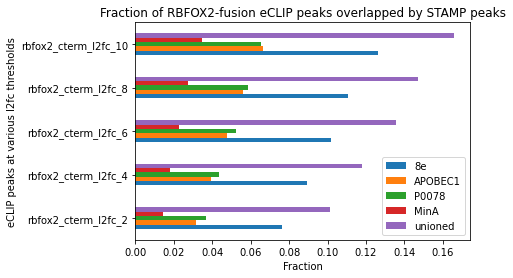

In [130]:
from matplotlib import pyplot as plt 

df_of_eclip_vals.plot(kind='barh')
plt.title("Fraction of RBFOX2-fusion eCLIP peaks overlapped by STAMP peaks")
plt.xlabel("Fraction")
plt.ylabel("eCLIP peaks at various l2fc thresholds")
plt.savefig("images/svgs/eCLIP_peaks_overlapped_by_stamp_indiv_vs_union.svg", bbox_inches='tight')

<AxesSubplot:>

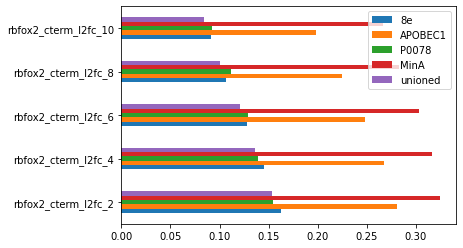

In [128]:
df_of_stamp_vals.plot(kind='barh')